In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FlowBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu2(self.conv2(self.relu1(self.conv1(x))))

class SimpleRIFE(nn.Module):
    def __init__(self):
        super(SimpleRIFE, self).__init__()
        # Encoder: extract features from the concatenated input frames (frame0 and frame1)
        self.encoder1 = FlowBlock(6, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = FlowBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = FlowBlock(128, 256)

        # Decoder: upsample and refine features
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.decoder1 = FlowBlock(256, 128)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.decoder2 = FlowBlock(128, 64)

        # Flow prediction: output 4 channels (2 for flow from frame0, 2 for frame1)
        self.flow_pred = nn.Conv2d(64, 4, kernel_size=3, padding=1)

    def forward(self, frame0, frame1, t=0.5):
        # Concatenate frames along the channel dimension (shape: [N, 6, H, W])
        x = torch.cat([frame0, frame1], dim=1)
        # Encoder
        x = self.encoder1(x)
        x = self.pool1(x)
        x = self.encoder2(x)
        x = self.pool2(x)
        x = self.encoder3(x)
        # Decoder
        x = self.up1(x)
        x = self.decoder1(x)
        x = self.up2(x)
        x = self.decoder2(x)
        # Predict flows: flow for frame0 and frame1
        flow = self.flow_pred(x)  # shape: [N, 4, H, W]
        flow0 = flow[:, :2, :, :]  # for frame0
        flow1 = flow[:, 2:, :, :]  # for frame1

        # Create normalized sampling grid
        grid = self.create_grid(frame0.size())  # shape: [N, H, W, 2]
        # Adjust grid by flows (scaled by t and 1-t)
        grid0 = grid + t * flow0.permute(0, 2, 3, 1)
        grid1 = grid - (1 - t) * flow1.permute(0, 2, 3, 1)

        # Warp the frames using grid_sample
        frame0_warp = F.grid_sample(frame0, grid0, align_corners=True)
        frame1_warp = F.grid_sample(frame1, grid1, align_corners=True)

        # Blend the warped frames to produce the intermediate frame
        mid_frame = (1 - t) * frame0_warp + t * frame1_warp
        return mid_frame

    def create_grid(self, size):
        # size: (N, C, H, W)
        N, C, H, W = size
        device = next(self.parameters()).device
        xs = torch.linspace(-1, 1, W, device=device)
        ys = torch.linspace(-1, 1, H, device=device)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=-1)  # shape: [H, W, 2]
        grid = grid.unsqueeze(0).repeat(N, 1, 1, 1)      # shape: [N, H, W, 2]
        return grid

# Example usage:
if __name__ == "__main__":
    # Instantiate the model
    model = SimpleRIFE()
    model.eval()
    # Dummy input frames (batch size 1, 3 channels, 128x128)
    frame0 = torch.randn(1, 3, 128, 128)
    frame1 = torch.randn(1, 3, 128, 128)
    with torch.no_grad():
        mid_frame = model(frame0, frame1, t=0.5)
    print("Generated intermediate frame shape:", mid_frame.shape)


Generated intermediate frame shape: torch.Size([1, 3, 128, 128])


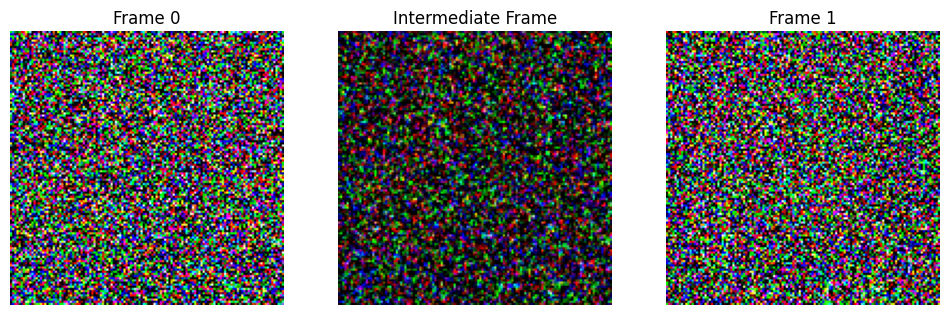

In [2]:
import matplotlib.pyplot as plt

def show_results(frame0, mid_frame, frame1):
    # Convert from [N, 3, H, W] to [H, W, 3]
    frame0_np = frame0.squeeze(0).permute(1, 2, 0).cpu().numpy()
    mid_frame_np = mid_frame.squeeze(0).permute(1, 2, 0).cpu().numpy()
    frame1_np = frame1.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Display the frames side-by-side
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(frame0_np)
    plt.title("Frame 0")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mid_frame_np)
    plt.title("Intermediate Frame")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(frame1_np)
    plt.title("Frame 1")
    plt.axis("off")

    plt.show()

# Example usage with your model:
if __name__ == "__main__":
    model.eval()
    frame0 = torch.randn(1, 3, 128, 128)
    frame1 = torch.randn(1, 3, 128, 128)
    with torch.no_grad():
        mid_frame = model(frame0, frame1, t=0.5)
    show_results(frame0, mid_frame, frame1)


In [3]:
import cv2
import os
import random

# Parameters
IMG_SIZE = (128, 128)     # Resize frames to a fixed resolution
NUM_INTERPOLATED = 1      # Number of frames to interpolate between the start and end
BATCH_SIZE = 64
EPOCHS = 10

def extract_frames(video_path):
    """Extracts all frames from a given video file."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def save_sequence(sequence, output_dir, video_name, seq_index):
    """Saves a sequence of frames into a dedicated subfolder."""
    seq_folder = os.path.join(output_dir, f"{video_name}_seq_{seq_index}")
    os.makedirs(seq_folder, exist_ok=True)
    for i, frame in enumerate(sequence):
        frame_path = os.path.join(seq_folder, f"frame_{i}.jpg")
        cv2.imwrite(frame_path, frame)

def generate_dataset(input_folder, train_folder, test_folder, num_interpolated=NUM_INTERPOLATED, train_ratio=0.8):
    """
    Processes each video in the input folder.

    For each video, a sliding window of length (num_interpolated + 2) is used
    to generate sequences where the first and last frames are the inputs for interpolation,
    and the frames in between are used as ground truth.

    Each sequence is randomly assigned to train or test.
    """
    # The total sequence length includes the starting and ending frames
    sequence_length = num_interpolated + 2

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".mp4"):
            video_path = os.path.join(input_folder, filename)
            video_name = os.path.splitext(filename)[0]
            frames = extract_frames(video_path)
            total_frames = len(frames)
            seq_index = 0
            # Slide a window over the frames to generate sequences
            for i in range(total_frames - sequence_length + 1):
                sequence = frames[i:i + sequence_length]
                # Randomly assign the sequence to training or testing set
                if random.random() < train_ratio:
                    save_sequence(sequence, train_folder, video_name, seq_index)
                else:
                    save_sequence(sequence, test_folder, video_name, seq_index)
                seq_index += 1


input_folder = "input"    # Folder containing your mp4 videos
train_folder = "train"    # Output folder for training sequences
test_folder = "test"      # Output folder for testing sequences
generate_dataset(input_folder, train_folder, test_folder)


In [ ]:
import os
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-4

class SimpleRIFE(nn.Module):
    def __init__(self):
        super(SimpleRIFE, self).__init__()
        self.encoder1 = nn.Sequential(nn.Conv2d(6, 64, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True))
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True))
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = nn.Sequential(nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True))
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(1024, 1024, 3, padding=1), nn.ReLU(inplace=True))
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.decoder1 = nn.Sequential(nn.Conv2d(1024, 512, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True))
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.decoder2 = nn.Sequential(nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True))
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.decoder3 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True))
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.decoder4 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True))
        self.flow_pred = nn.Conv2d(64, 4, 3, padding=1)

    def forward(self, frame0, frame1, t=0.5):
        x = torch.cat([frame0, frame1], dim=1)
        x = self.encoder1(x)
        x = self.pool1(x)
        x = self.encoder2(x)
        x = self.pool2(x)
        x = self.encoder3(x)
        x = self.pool3(x)
        x = self.encoder4(x)
        x = self.pool4(x)
        x = self.bottleneck(x)
        x = self.up1(x)
        x = self.decoder1(x)
        x = self.up2(x)
        x = self.decoder2(x)
        x = self.up3(x)
        x = self.decoder3(x)
        x = self.up4(x)
        x = self.decoder4(x)
        flow = self.flow_pred(x)
        flow0 = flow[:, :2, :, :]
        flow1 = flow[:, 2:, :, :]
        grid = self.create_grid(frame0.size())
        grid0 = grid + t * flow0.permute(0, 2, 3, 1)
        grid1 = grid - (1-t) * flow1.permute(0, 2, 3, 1)
        frame0_warp = F.grid_sample(frame0, grid0, align_corners=True)
        frame1_warp = F.grid_sample(frame1, grid1, align_corners=True)
        mid_frame = (1-t)*frame0_warp + t*frame1_warp
        return mid_frame

    def create_grid(self, size):
        N, C, H, W = size
        device = next(self.parameters()).device
        xs = torch.linspace(-1, 1, W, device=device)
        ys = torch.linspace(-1, 1, H, device=device)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=-1)
        grid = grid.unsqueeze(0).repeat(N, 1, 1, 1)
        return grid

class FrameInterpolationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.sequence_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    def __len__(self):
        return len(self.sequence_dirs)
    def __getitem__(self, idx):
        seq_path = self.sequence_dirs[idx]
        f0 = cv2.imread(os.path.join(seq_path, "frame_0.jpg"))
        f1 = cv2.imread(os.path.join(seq_path, "frame_1.jpg"))
        f2 = cv2.imread(os.path.join(seq_path, "frame_2.jpg"))
        f0 = cv2.cvtColor(f0, cv2.COLOR_BGR2RGB)
        f1 = cv2.cvtColor(f1, cv2.COLOR_BGR2RGB)
        f2 = cv2.cvtColor(f2, cv2.COLOR_BGR2RGB)
        f0 = cv2.resize(f0, IMG_SIZE)
        f1 = cv2.resize(f1, IMG_SIZE)
        f2 = cv2.resize(f2, IMG_SIZE)
        f0 = f0.astype(np.float32)/255.0
        f1 = f1.astype(np.float32)/255.0
        f2 = f2.astype(np.float32)/255.0
        f0 = torch.from_numpy(f0).permute(2,0,1)
        f1 = torch.from_numpy(f1).permute(2,0,1)
        f2 = torch.from_numpy(f2).permute(2,0,1)
        return f0, f2, f1

def show_results(frame0, mid_frame, gt_frame):
    frame0_np = frame0.squeeze(0).permute(1,2,0).cpu().numpy()
    mid_frame_np = mid_frame.squeeze(0).permute(1,2,0).cpu().detach().numpy()
    gt_frame_np = gt_frame.squeeze(0).permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(frame0_np)
    plt.title("Frame 0")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(mid_frame_np)
    plt.title("Predicted Frame")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(gt_frame_np)
    plt.title("Ground Truth")
    plt.axis("off")
    plt.show()

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for f0, f2, gt in dataloader:
        f0, f2, gt = f0.to(device), f2.to(device), gt.to(device)
        optimizer.zero_grad()
        pred = model(f0, f2, t=0.5)
        loss = criterion(pred, gt)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * f0.size(0)
    return running_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for f0, f2, gt in dataloader:
            f0, f2, gt = f0.to(device), f2.to(device), gt.to(device)
            pred = model(f0, f2, t=0.5)
            loss = criterion(pred, gt)
            running_loss += loss.item() * f0.size(0)
    return running_loss / len(dataloader.dataset)

if __name__=="__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleRIFE().to(device)
    train_dataset = FrameInterpolationDataset("train")
    test_dataset = FrameInterpolationDataset("test")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    for epoch in range(EPOCHS):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    model.eval()
    f0, f2, gt = next(iter(test_loader))
    f0, f2, gt = f0.to(device), f2.to(device), gt.to(device)
    with torch.no_grad():
        pred = model(f0, f2, t=0.5)
    show_results(f0[0:1], pred[0:1], gt[0:1])


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10, Train Loss: 0.005379, Val Loss: 0.004563
